In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import claude.utils as cu
from claude.tx import qammod
from claude.models.NLIN import defaultParameters,\
                               calcAseNoisePower,\
                               calcIntraConstants,calcInterConstants,\
                               calcIntraChannelNLIN,calcInterChannelNLIN,\
                               calcIntraChannelGN,calcInterChannelGN

In [2]:
# System parameters
param = defaultParameters()

param.M = 64
constellation = qammod(param.M)

power = np.mean(np.abs(constellation)**2)
param.kur  = np.mean(np.abs(constellation)**4) / power**2
param.kur3 = np.mean(np.abs(constellation)**6) / power**3

print(param)

lambda_:	1.55003597538907e-06
Fc:	193410000000000.0
PolMux:	1
gamma:	1.3
D:	16.464
beta2:	20.999953937404488
alpha:	0.2
Nspan:	20
L:	100
PD:	0
PdBm:	2
BaudRate:	32
ChSpacing:	50
kur:	1.3809523809523807
kur3:	2.225785552316164
N_mc:	1000000
NF:	5
M:	64



In [3]:
# Calculate System constants
channels = np.array([-100., -50., 50., 100.])
nChannels = channels.size
chi = np.zeros( (2,nChannels) )
for ii,channel in enumerate(channels):
    param.ChSpacing = channel
    chi[:,ii] = calcInterConstants(param)
X = calcIntraConstants(param)
calcAseNoisePower = calcAseNoisePower(param)

In [4]:
# Sweep power and calculate different NLIN and GN interference
powerSweep = np.arange(-10,6)
NLINinter = np.zeros(powerSweep.shape)
NLINintra = np.zeros(powerSweep.shape)

GNinter = np.zeros(powerSweep.shape)
GNintra = np.zeros(powerSweep.shape)

for ii,PdBm in enumerate(powerSweep):
    param.PdBm = PdBm
    NLINinter[ii] = np.sum( calcInterChannelNLIN(chi,param) )
    NLINintra[ii] = calcIntraChannelNLIN(X,param)[0]
    
    GNinter[ii] = np.sum( calcInterChannelGN(chi,param) )
    GNintra[ii] = calcIntraChannelGN(X,param)[0]

In [5]:
# effective SNR
NLINeffSNR = powerSweep - cu.lin2dB( calcAseNoisePower+NLINinter+NLINintra, 'dBm')
GNeffSNR = powerSweep - cu.lin2dB( calcAseNoisePower+GNinter+GNintra, 'dBm')

In [6]:
# Nonlinear Wizard http://nlinwizard.eng.tau.ac.il
wizard_powerSweep = [-10, -8, -6,-4, -2, 0, 2, 4]
wizard_effSNR = [5.91,7.90, 9.88, 11.80, 13.49, 14.43, 13.73, 11.20]

In [7]:
# Fehenberger GN https://www.fehenberger.de/#sourcecode
fehen_powerSweep = [-10, -8, -6, -4, -2, 0, 2, 4]
fehen_effSNR = [5.9016, 7.8922, 9.8550, 11.7102, 13.1774, 13.5348, 12.0059, 8.9346]

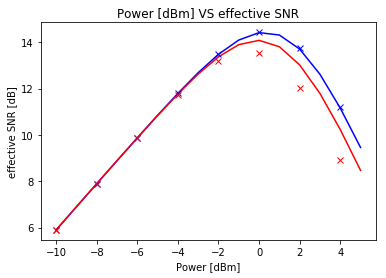

In [8]:
plt.plot(powerSweep, NLINeffSNR,'b')
plt.plot(powerSweep, GNeffSNR,'r')
plt.plot(wizard_powerSweep, wizard_effSNR,'bx')
plt.plot(fehen_powerSweep, fehen_effSNR,'rx')
plt.title('Power [dBm] VS effective SNR')
plt.xlabel('Power [dBm]')
plt.ylabel('effective SNR [dB]')
plt.show()